**THE FLY WILL EXPLORE THE ARENA BASED ON ITS INTERNAL STATE(MATING STATE, FOOD STOCK LEVEL)**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
from tqdm import trange
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case yeast). If it's (0, x) then it's in the 2nd dimension (in this case
# sucrose)
peak_intensity = np.array([[1, 0], [0, 1], [2, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
#marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
#marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1,2,20]

logging.basicConfig(level=logging.INFO)

In [16]:
# Set up the arena
arena = OdorArena(
     odor_source=odor_source,
     peak_intensity=peak_intensity,
     odor_valence=odor_valence,
     diffuse_func=lambda x: x**-2,
     marker_size=0.3,
 )

(-0.5, 799.5, 607.5, -0.5)

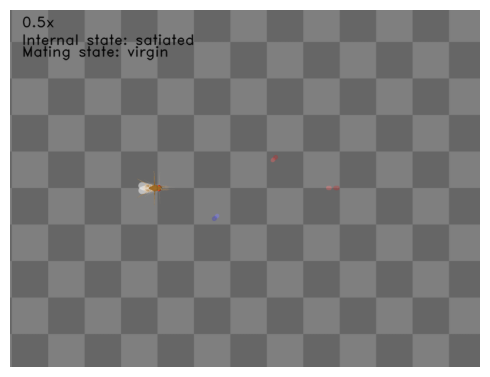

In [17]:
# Add the NeuroMechFLy

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
    food_loss_rate = 0.00003,
    food_stocked_init=1.0,
    mating_state="virgin",
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
#fig.savefig("./outputs/olfaction_env.png") 

In [18]:
# Let the exploration begin

decision_interval = 0.01
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
logging.info("Number of decision steps: ", num_decision_steps)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

# Bool to see if simulation is done
sim_end = False
# Get fly's hunger state
hunger_limits = sim.food_requirements
# To keep track of the previous internal state
prev_int_state = ""
# Intialize gains
attractive_gain = 0
aversive_gain = 0

# Run simulation
# For each decision step
for i in trange(num_decision_steps):
    if not sim_end:
        # Check where the fly's hunger level is at
        int_state = sim.compute_internal_state()
        # Change gains only if the internal state has changed
        if int_state != prev_int_state:
            logging.info("Internal state changed to: ", int_state)
            att_gain, av_gain = arena.generate_random_gains_food_internal_state(int_state, sim.mating_state, obs["fly"][0])
            attractive_gain = att_gain
            aversive_gain = av_gain
            logging.debug("Attractive gain: ", attractive_gain)
            logging.debug("Aversive gain: ", aversive_gain)


        # Compute bias from odor intensity & control signal
        if int_state == "starving":
            # the fly will reach the closest yeast source
            yeast_source = sim.compute_closest_yeast_source(obs) 
            control_signal = arena.generate_specific_turning_control(yeast_source, sim, attractive_gain)
        elif int_state == "hungry":
            # the fly will reach the yeast source that is the richest one
            yeast_source = arena.compute_richest_yeast_source()
            control_signal = arena.generate_specific_turning_control(yeast_source, sim, attractive_gain)
        else:
            # the fly will explore the arena accordingly to its mating state
            # virgin -> sucrose
            # mated -> yeast
            control_signal = arena.generate_exploration_turning_control(attractive_gain, aversive_gain, obs)
        # Make environment step and reward fly if it gets to a food source
        for _ in range(physics_steps_per_decision_step):
            obs, reward, terminated, truncated, _ = sim.step(control_signal)
            rendered_img = sim.render()
            if rendered_img is not None:
                # record odor intensity too for video
                odor_history.append(obs["odor_intensity"])
            obs_hist.append(obs)

            # If fly gets to food source, simulation does not end
            # fly keeps walking based on its internal state
            if reward != None:
                #sim_end = True
                yeast_source_reward = sim.compute_closest_yeast_source()
                logging.info("Fly got to food source", yeast_source_reward)
                logging.info("Elapsed time in the simulation", sim.curr_time)
                #break
            # If fly has no food left, end simulation (death)
            #if obs["food_stocked"] < 0:
            #    sim_end = True
            #    logging.info("Fly died")
            #    break

            # If simulation should be terminated or truncted, end simulation
            if terminated:
                logging.info("Out of time")
                logging.info("Elapsed time in the simulation", sim.curr_time)
                sim_end = True
                break
            if truncated:
                logging.info("No food source was reached, simulation is truncated")
                logging.info("Elapsed time in the simulation", sim.curr_time)
                sim_end = True
                break

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


In [19]:
# choose a name to save both the video and the trajectory
name = "internal_state_simulation_more_simulation_time"
path = Path(f"flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

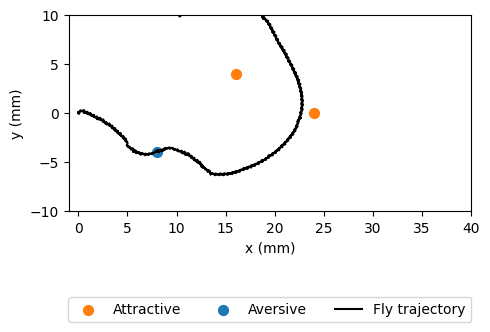

In [20]:
#Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:orange", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(f"flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png")

In [21]:
# save the video
sim.save_video(f"flygym-scratch/outputs/plots/{name}/odor_taxis_video.mp4")

**IF THE SIMULATION WAS TRUNCATED, WE START AGAIN**

In [11]:
if sim_end == True and truncated:
    _, _ = sim.respawn()
    logging.info("Let's restart")

In [ ]:
# Bool to see if simulation is done
sim_end = False
# Get fly's hunger state
hunger_limits = sim.food_requirements
# To keep track of the previous internal state
prev_int_state = ""
# Intialize gains
attractive_gain = 0
aversive_gain = 0

# Run simulation
# For each decision step
for i in trange(num_decision_steps):
    if not sim_end:
        # Check where the fly's hunger level is at
        int_state = sim.compute_internal_state()
        # Change gains only if the internal state has changed
        if int_state != prev_int_state:
            logging.info("Internal state changed to: ", int_state)
            att_gain, av_gain = arena.generate_random_gains_food_internal_state(int_state, sim.mating_state, obs["fly"][0])
            attractive_gain = att_gain
            aversive_gain = av_gain
            logging.debug("Attractive gain: ", attractive_gain)
            logging.debug("Aversive gain: ", aversive_gain)


        # Compute bias from odor intensity & control signal
        if int_state == "starving":
            yeast_source = sim.compute_closest_yeast_source(obs) 
            control_signal = arena.generate_specific_turning_control(yeast_source, sim, attractive_gain)
        elif int_state == "hungry":
            yeast_source = arena.compute_richest_yeast_source()
            control_signal = arena.generate_specific_turning_control(yeast_source, sim, attractive_gain)
        else:
            control_signal = arena.generate_exploration_turning_control(attractive_gain, aversive_gain, obs)
        # Make environment step and reward fly if it gets to a food source
        for _ in range(physics_steps_per_decision_step):
            obs, reward, terminated, truncated, _ = sim.step(control_signal)
            rendered_img = sim.render()
            if rendered_img is not None:
                # record odor intensity too for video
                odor_history.append(obs["odor_intensity"])
            obs_hist.append(obs)

            # If fly gets to food source, simulation does not
            if reward != None:
                #sim_end = True
                logging.info("Fly got to food source")
                logging.info("Elapsed time in the simulation", sim.curr_time)
                #break
            # If fly has no food left, end simulation (death)
            #if obs["food_stocked"] < 0:
            #    sim_end = True
            #    logging.info("Fly died")
            #    break

            # If simulation should be terminated or truncted, end simulation
            if terminated:
                logging.info("Out of time")
                logging.info("Elapsed time in the simulation", sim.curr_time)
                sim_end = True
                break
            if truncated:
                logging.info("No food source was reached, simulation is truncated")
                logging.info("Elapsed time in the simulation", sim.curr_time)
                sim_end = True
                break